In [3]:
import math
import random
import rdkit
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.rdmolfiles import SmilesMolSupplier
import pandas as pd
import numpy as np
import pickle

In [17]:
prm = dict(
  #morgan fingerpring bit length
  FP_BITS = 1024
)

In [126]:
# model_df = pd.read_csv('model_df.csv')
# model_df = model_df.drop(['index'],axis=1)

# data = {}
# for i in range(len(model_df)):
#     fp = []
#     for j in range(1,257):
#         colname = 'sm' + str(j)
#         fp.append(model_df.iloc[i][colname])
#     fp = [str(int(x)) for x in fp]
#     fp_str = ''.join(fp)
#     data[fp_str] = model_df.iloc[i]['resp_categorical']

In [18]:
def visualize(smi_file):
    # load molecules from file
    mols = SmilesMolSupplier(smi_file, sanitize=True, nameColumn=-1,titleLine=True)

    n_samples = 40
    mols_list = [mol for mol in mols]
    mols_sampled = random.sample(mols_list, n_samples)  # sample 100 random molecules to visualize

    mols_per_row = int(math.sqrt(n_samples))            # make a square grid

    png_filename=smi_file[:-3] + "png"  # name of PNG file to create

    #labels=list(range(n_samples))       # label structures with a number

    labels = []
    scoring_model = pickle.load(open('new_model/Protac_Scoring_Model_1024.pkl', 'rb'))
    with open('new_model/features_1024.pkl','rb') as fp:
        features = pickle.load(fp)

    print(len(features))
    
    for m in mols_sampled:
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=prm['FP_BITS'])
        fp_array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fingerprint, fp_array)
        input = list(0 for i in range(88)) + list(fp_array) + list(0 for i in range(161))

        #need to add a 1 for target and a 1 for cell type
        tgt_ind = features.index("tgt_ER")
        ct_ind = features.index("ct_HeLa")
        e3_ind = features.index("e3_IAP")
        input[tgt_ind] = 1
        input[ct_ind] = 1
        input[e3_ind] = 1

        output = scoring_model.predict([input])
        activity_score = output[0].argmax()
        labels.append(activity_score)

    #draw the molecules (creates a PIL image)
    img = MolsToGridImage(mols=mols_sampled,
                        molsPerRow=mols_per_row,
                        legends=[str(i) for i in labels])
    return img
    #img.save(png_filename)

1274


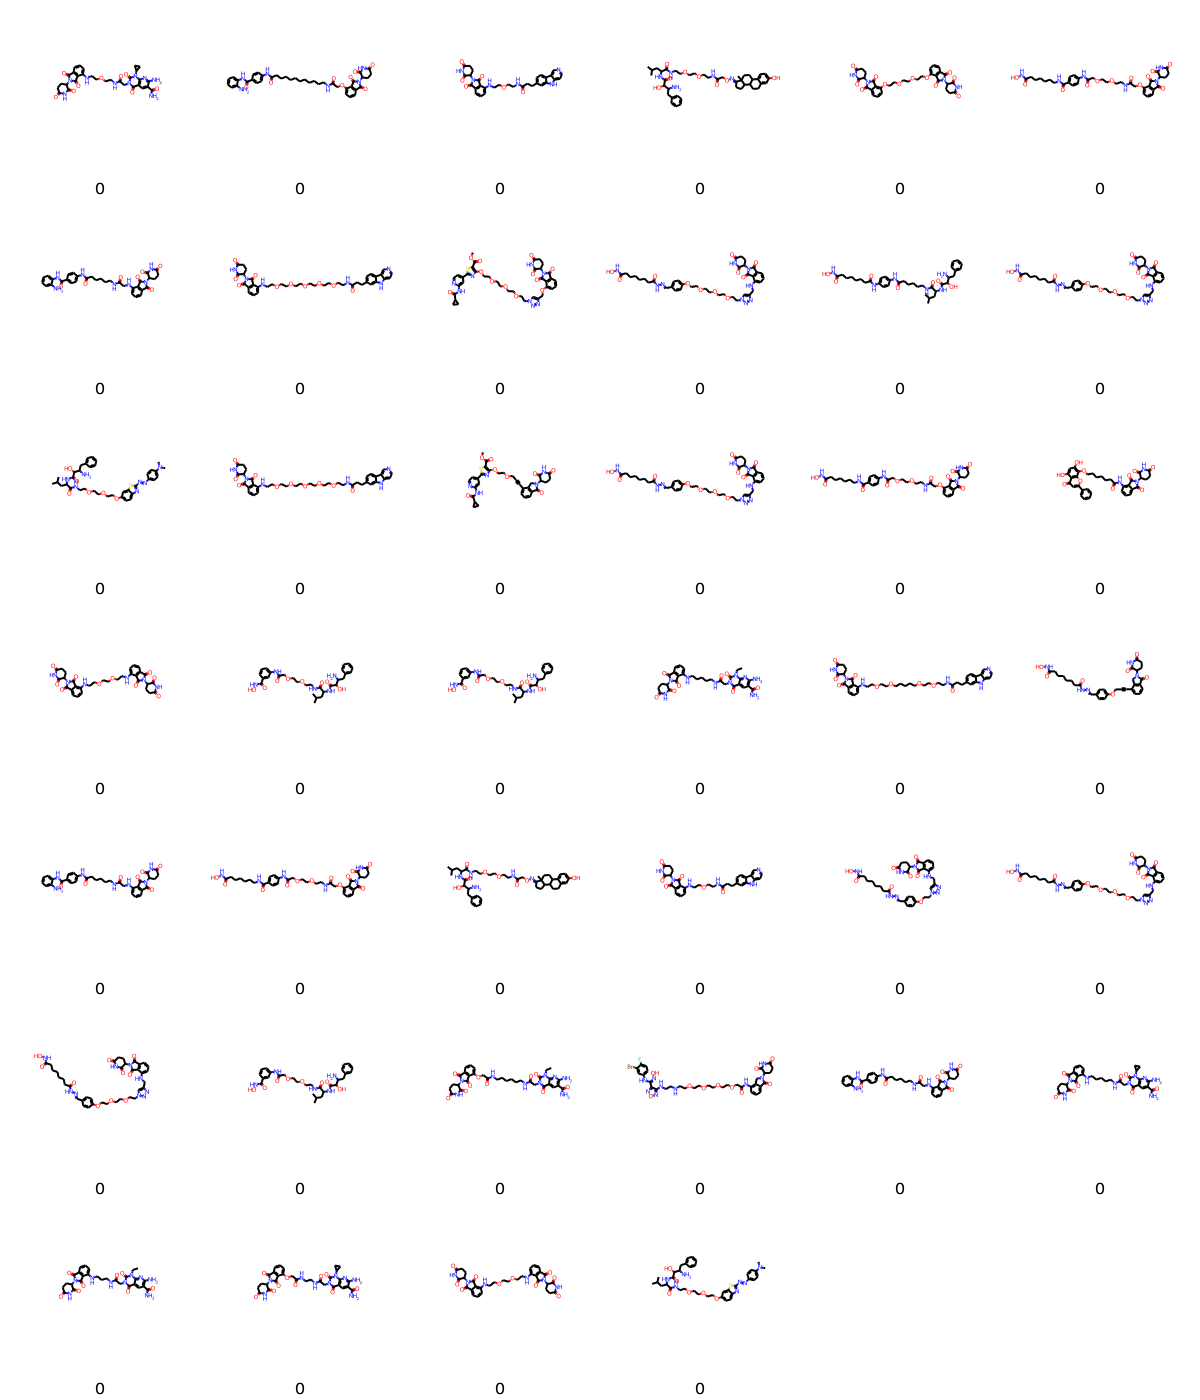

In [19]:
visualize("epoch_100.smi")

762


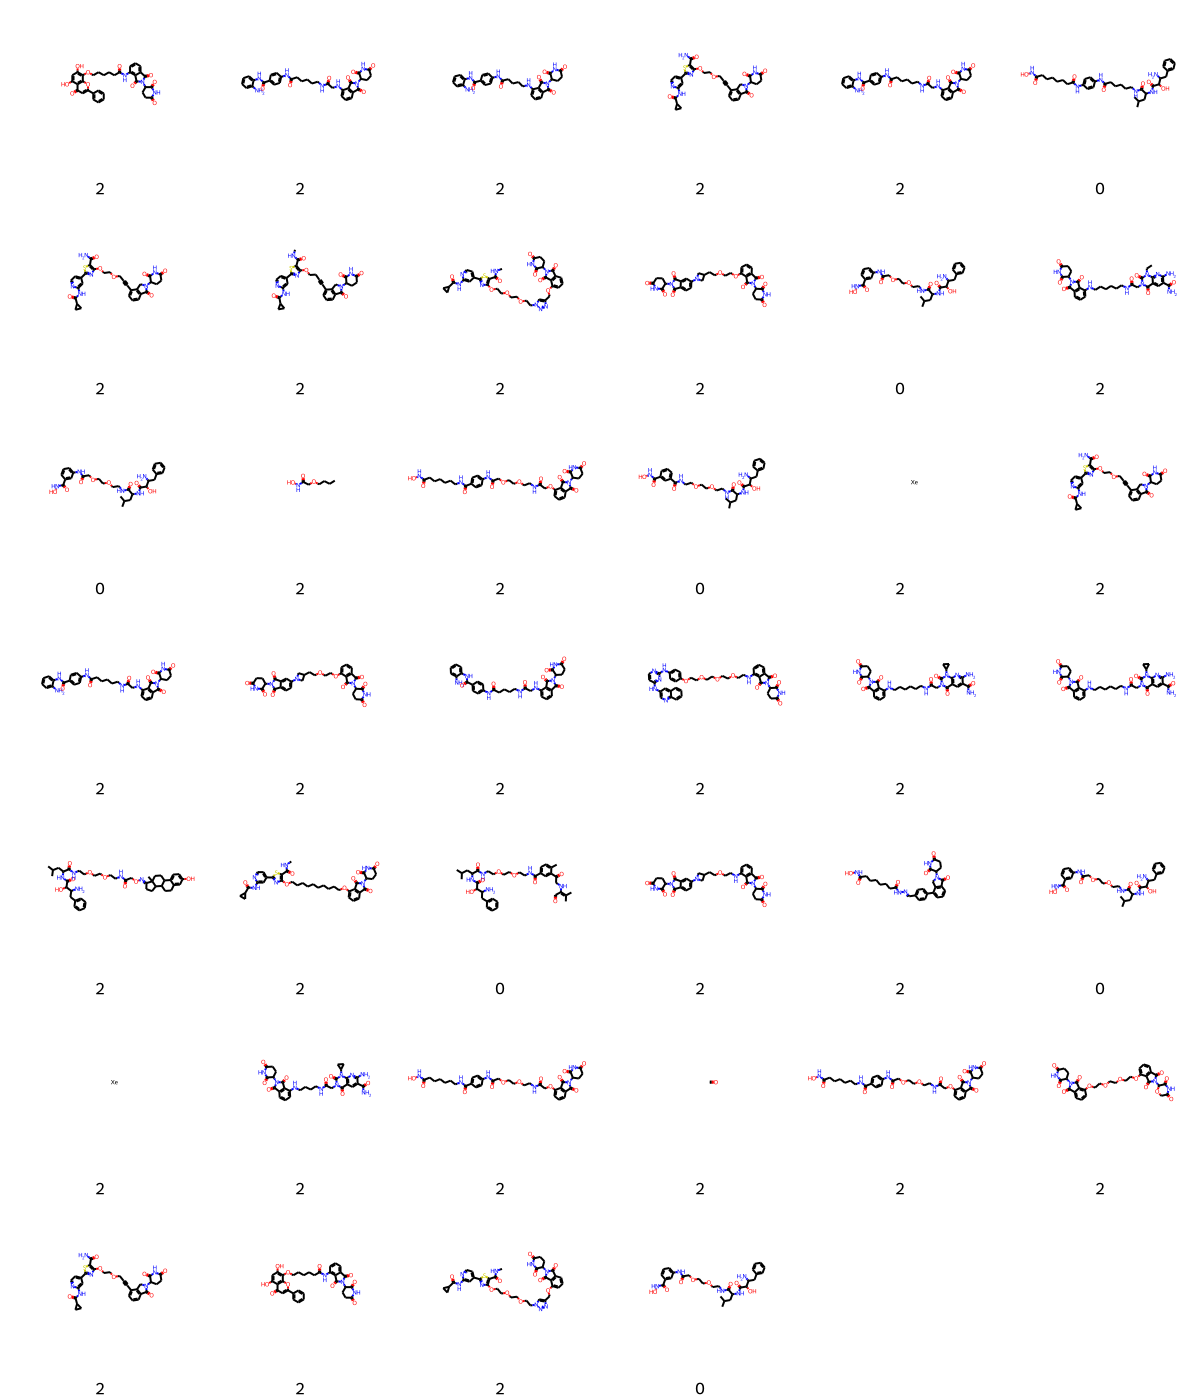

In [16]:
visualize("epoch_GEN80.smi")

1274


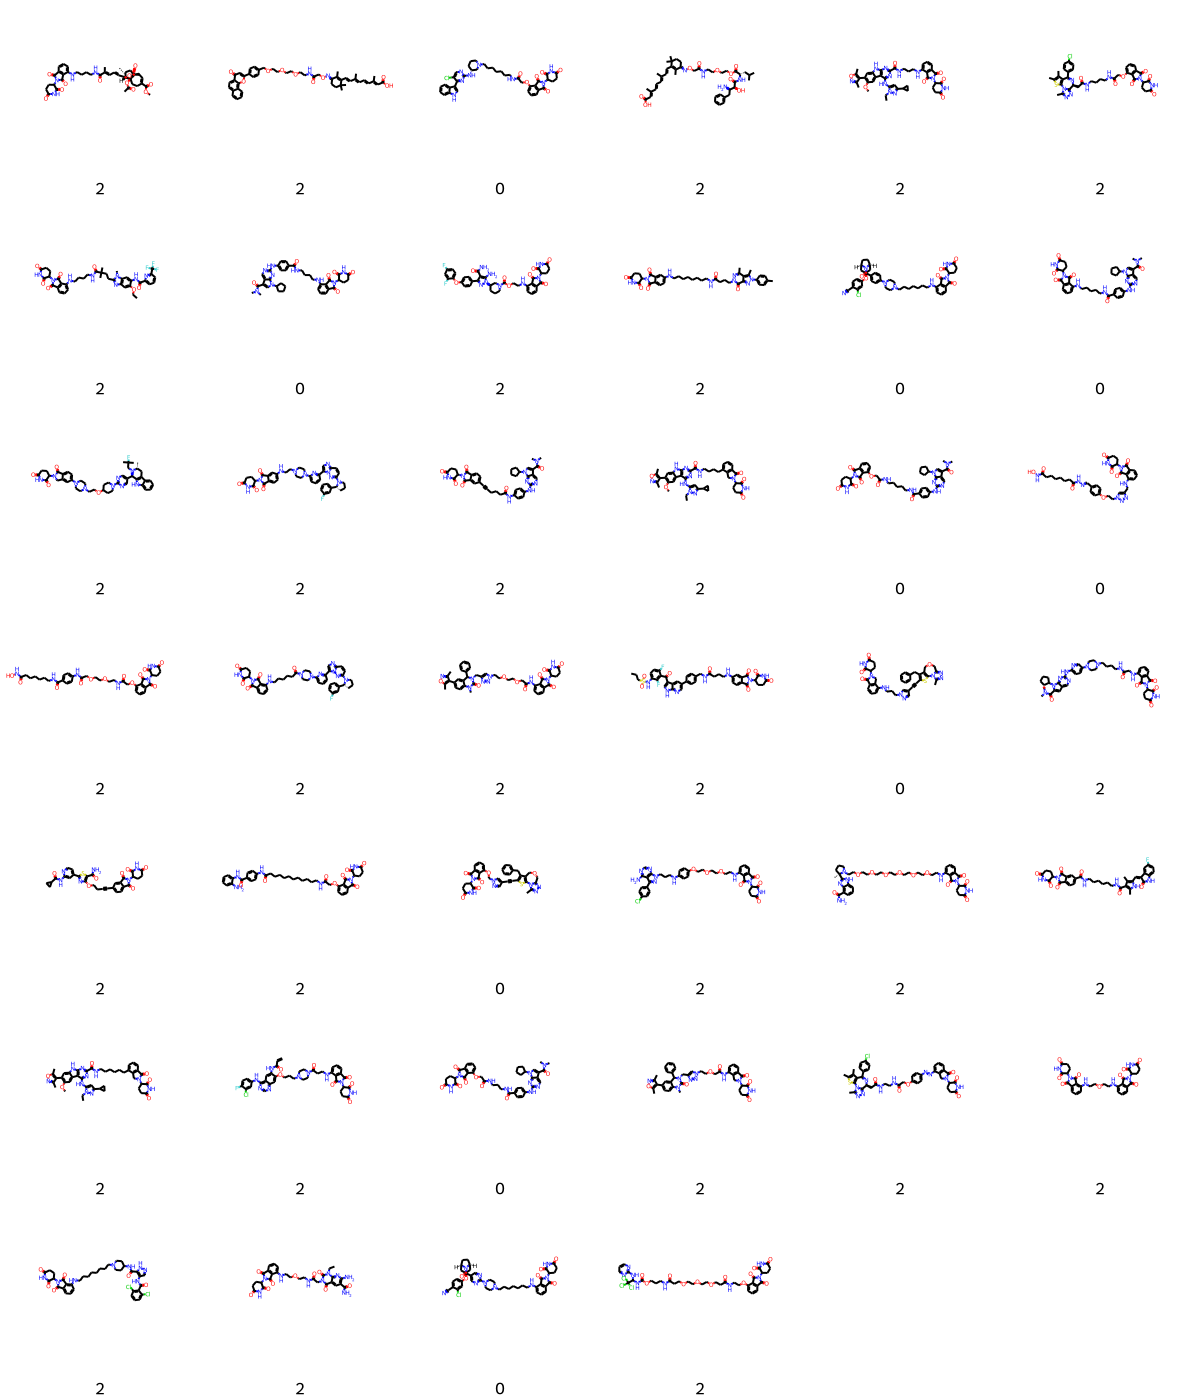

In [153]:
visualize("test.smi")

1274


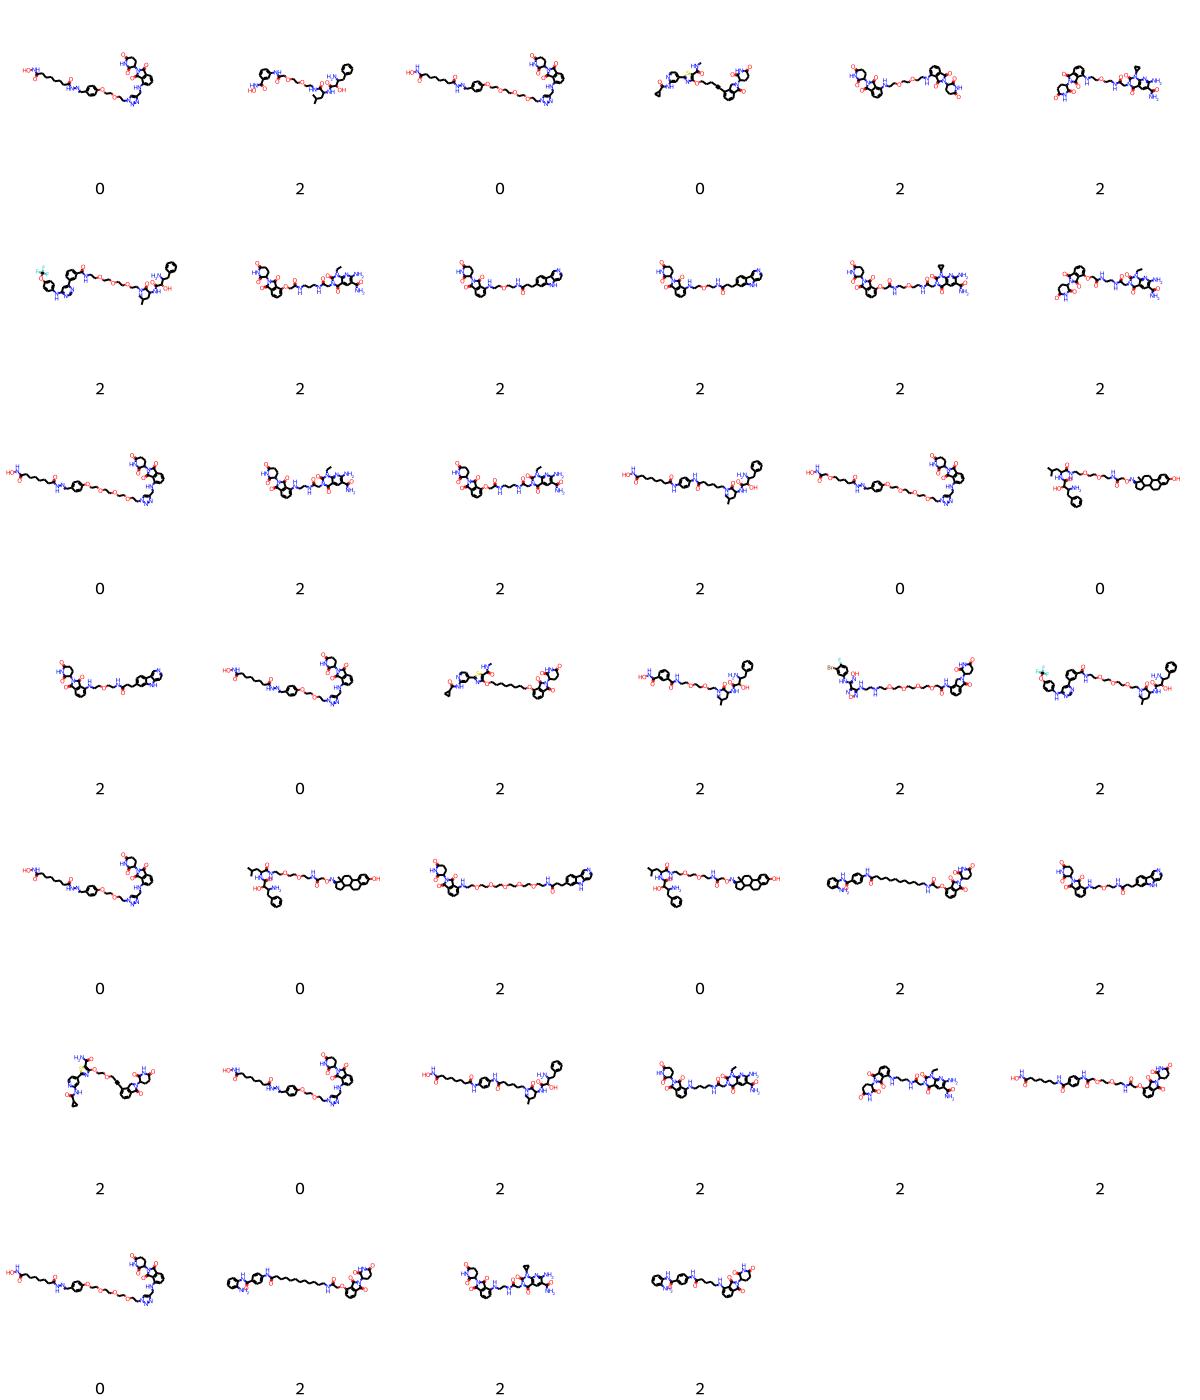

In [154]:
visualize("epoch_100.smi")

In [144]:
data = {}
model_df = pd.read_csv("model_df.csv")
model_df.drop(['index'],axis=1)
for i in range(len(model_df)):
    fp = []
    for j in range(1,prm['FP_BITS']+1):
        colname = "sm" + str(j)
        fp.append(int(model_df.iloc[i][colname]))
    fp_str = ''.join(str(n) for n in fp)
    data[fp_str] = (i,model_df.iloc[i]["resp_categorical"])

In [150]:
def visualize_train(smi_file, data):
    # load molecules from file
    mols = SmilesMolSupplier(smi_file, sanitize=True, nameColumn=-1,titleLine=True)

    n_samples = 100
    mols_list = [mol for mol in mols]
    mols_sampled = random.sample(mols_list, n_samples)  # sample 100 random molecules to visualize
    png_filename=smi_file[:-3] + "png"  # name of PNG file to create

    #labels=list(range(n_samples))       # label structures with a number

    labels = []
    scoring_model = pickle.load(open('protac_scoring_models/Protac_Scoring_Model_1024.pkl', 'rb'))
    with open('protac_scoring_models/features_1024.pkl','rb') as fp:
        features = pickle.load(fp)    

    n_samples_new = 0
    mols_sampled_new = []
    true_labels = []
    for m in mols_sampled:
        try:
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=prm['FP_BITS'])
            fp_array = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fingerprint, fp_array)
            input = list(0 for i in range(88)) + list(fp_array) + list(0 for i in range(161))
            # fp_lst = fp_array.tolist()
            # input = list(fp_array)
            # fp_str = ''.join(str(n) for n in fp_lst)
            fp_str = ''.join(str(n) for n in list(fp_array))
            score = data[fp_str][1]

            model_df = pd.read_csv("model_df.csv")
            model_df.drop(['index'],axis=1)
            row = data[fp_str][0]
            all_cols = model_df.columns.tolist()
            for col in all_cols:
                val = int(model_df.iloc[row][col])
                if val == 1:
                    if 'tgt' in str(col):
                        tgt_col = str(col)
                    elif 'ct' in str(col):
                        ct_col = str(col)
                    elif 'e3' in str(col):
                        e3_col = str(col)

            #need to add a 1 for target and a 1 for cell type
            tgt_ind = features.index(tgt_col)
            ct_ind = features.index(ct_col)
            e3_ind = features.index(e3_col)
            input[tgt_ind] = 1
            input[ct_ind] = 1
            input[e3_ind] = 1

            output = scoring_model.predict([input])
            activity_score = output[0].argmax()
            labels.append(activity_score)
            n_samples_new+=1
            mols_sampled_new.append(m)
            true_labels.append(int(score))
        except:
            pass

    print(n_samples_new)
    mols_per_row = int(math.sqrt(n_samples_new))            # make a square grid
    #draw the molecules (creates a PIL image)
    img = MolsToGridImage(mols=mols_sampled_new,
                        molsPerRow=mols_per_row,
                        legends=[str(true_labels[i])+ ', ' + str(labels[i]) for i in range(len(true_labels))])
    total = len(labels)
    n = 0
    for i in range(total):
        if labels[i]==true_labels[i]:
            n+=1
    print(n/total)
    return img
    #img.save(png_filename)

17
0.7058823529411765


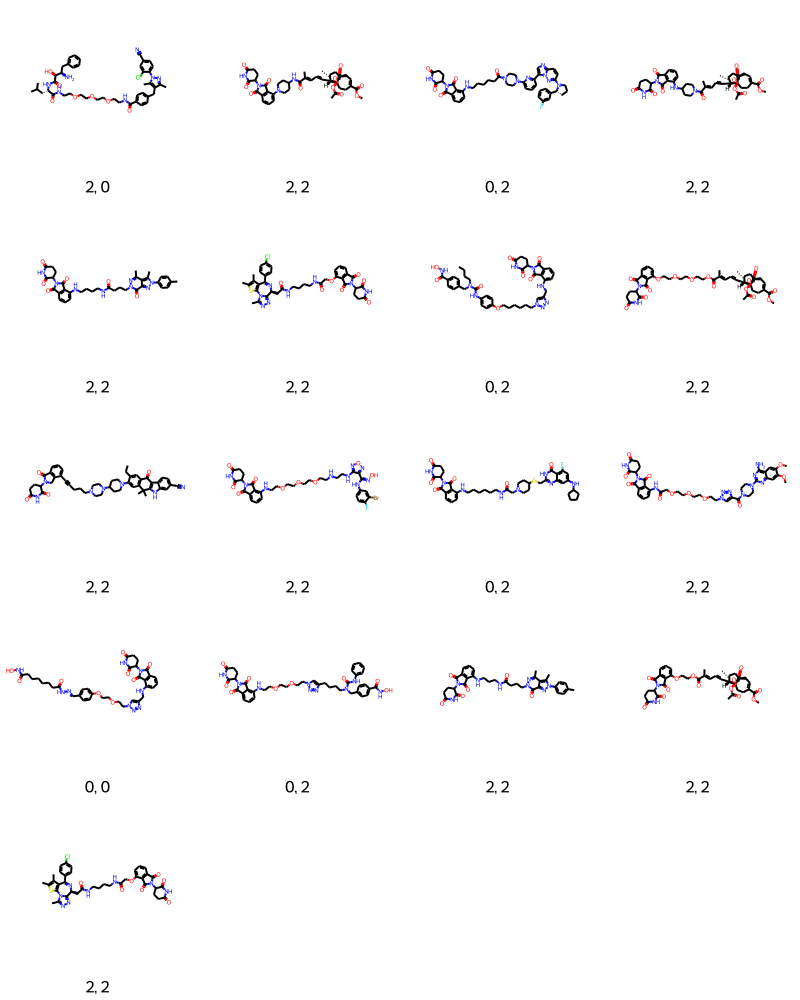

In [151]:
visualize_train("train.smi",data)